# Final Project, CS6190 Probabilistic Modeling
# Predicting Soccer Results

### Amir Mirbagheri
### Hossein Moghimifam



The goal of this project is to predict the results of upcoming matches based on previous results in a Primier League season.
Three different method are utilized and their accuracy is compared.

1) Bayesian Logistic Regression using HMC as sampler
    the HMC code was reproduced from Neal 2012, available at https://arxiv.org/pdf/1206.1901.pdf.
    <br>
    $$U=\sum_{i=1}^n (1-y_i)x^T_i\beta+log(1+e^{-x_i^T\beta})-\frac{1}{2\sigma^2}||\beta||^2$$
    <br>
For predicting the results, "y" has been assumed as a $3 \times n$ matrix. In each row, only one element can be 1 and the other 2 should be 0. The probability for each column is calculated separately using Bayesian Logistic Regression, and the one with highest probability is set as 1, and the other two as 0. Where:
$$P(y_k)=\dfrac{1}{1+e^{-X \beta}}$$
<br>
Machine Learning Algorithms:
<br>
2) Support Vector Machine (SVM)
<img src="SVMML.JPG">
$$
\begin{align}
&Minimize \quad \frac12 ||w||^2\\
&subject \quad to \quad y_i(w^Tx_i+b)\geq1 
\end{align}$$
3) Logistic Regression with MLE
<img src="LR.JPG">
The parameters for each method is then optimized, and the result is compared to the prediction of BET365.

You can download data of English premier league 2016/2017 from:
http://football-data.co.uk/englandm.php

These are the features extracted from that data:
<br>
HomeTeam = Home Team 
<br>
AwayTeam = Away Team
<br>
FTHG and HG = Full Time Home Team Goals
<br>
FTAG and AG = Full Time Away Team Goals
<br>
FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)
<br>
HS = Home Team Shots
<br>
AS = Away Team Shots
<br>
HST = Home Team Shots on Target
<br>
AST = Away Team Shots on Target
<br>
B365H = Bet365 home win odds
<br>
B365D = Bet365 draw odds
<br>
B365A = Bet365 away win odds

In [1]:
import pandas as pd
import numpy as np
df1=pd.read_csv('E0.csv',usecols=['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HS','AS','HST','AST'
,'B365H','B365D','B365A'])
df1.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,B365H,B365D,B365A
0,Burnley,Swansea,0,1,A,10,17,3,9,2.40,3.3,3.25
1,Crystal Palace,West Brom,0,1,A,14,13,4,3,2.00,3.3,4.50
2,Everton,Tottenham,1,1,D,12,13,6,4,3.20,3.4,2.40
3,Hull,Leicester,2,1,H,14,18,5,5,4.50,3.6,1.91
4,Man City,Sunderland,2,1,H,16,7,4,3,1.25,6.5,15.00


Now let's check the percentage of home win,away win and draw 

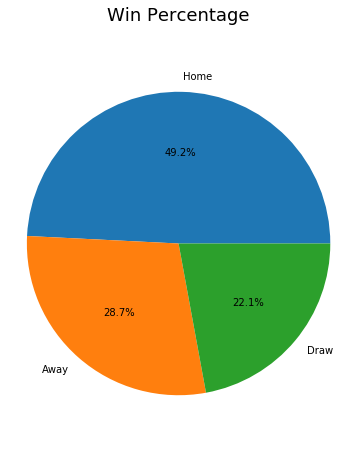

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,8))
plt.pie(df1['FTR'].value_counts(),labels=['Home','Away','Draw'], autopct='%1.1f%%',shadow=False, startangle=0)
plt.axis('equal')
plt.title('Win Percentage', size=18)
plt.show()

This pie graph shows the home team has higher chance to win the game. We can find confidence interval for our hypothesis.

In [3]:
from statsmodels.stats import proportion
conf=proportion.proportion_confint((df1['FTR']=='H').sum(), df1['FTR'].count(), alpha=0.05, method='normal')
print('The chance of home team to win with %95 confidence interval falls in :{}'.format(conf))

The chance of home team to win with %95 confidence interval falls in :(0.44183951466813098, 0.54237101164765844)


Team strengths data have been acquired from http://www.squawka.com/, and added to the previous data. These would add the effect of team attack, defense and possession capabilities.

In [4]:
##add new data to data frame
dfSq=pd.read_csv('dataE0.csv',index_col='Team').dropna(axis=0,how='any')
##Hde: Home Defense    Hatt: Home Attack    Hpo: Home possession    Htot : Home total power  
##Ade: Away defense   Aatt: away attack    Apo : Away possession :  Atot: Away total power
dfSq.head()
dff=df1.join(dfSq[['Hde','Hatt','Hpo','Htot']],on='HomeTeam')
df=dff.join(dfSq[['Ade','Aatt','Apo','Atot']],on='AwayTeam')

In [5]:
df.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,B365H,B365D,B365A,Hde,Hatt,Hpo,Htot,Ade,Aatt,Apo,Atot
0,Burnley,Swansea,0,1,A,10,17,3,9,2.40,3.3,3.25,33.53,50.34,-41.32,42.55,-1.58,36.53,-17.24,17.71
1,Crystal Palace,West Brom,0,1,A,14,13,4,3,2.00,3.3,4.50,18.53,47.68,-26.71,39.47,6.79,39.21,-45.00,-12.29
2,Everton,Tottenham,1,1,D,12,13,6,4,3.20,3.4,2.40,51.00,87.66,-9.21,129.42,27.34,80.92,3.34,111.61
3,Hull,Leicester,2,1,H,14,18,5,5,4.50,3.6,1.91,10.53,48.87,-23.13,36.24,-4.50,36.71,-44.50,-12.29
4,Man City,Sunderland,2,1,H,16,7,4,3,1.25,6.5,15.00,12.84,82.34,35.37,130.53,20.00,38.58,-29.37,29.18


Making features for our model (As an obvious fact we do not know the results for the game that we are predicting! so we need to make some features based on the previous results for every match):

We defined a momentum which gives the average of five previous games for each team. It could be helpful to make our model more accurate. If for example some team in the five previous games shows poor results or great results, we can track them.
<br>

In [6]:
def make_data(df):
    ##add points for away and home team : win 3 points, draw 1 point, loss 0 point
    df['HP']=np.select([df['FTR']=='H',df['FTR']=='D',df['FTR']=='A'],[3,1,0])
    df['AP']=np.select([df['FTR']=='H',df['FTR']=='D',df['FTR']=='A'],[0,1,3])
    ## add difference in goals for home and away team
    df['HDG']=df['FTHG']-df['FTAG']
    df['ADG']=-df['FTHG']+df['FTAG']
    ##add momentum to data 
    cols=['Team','Points','Goal','Shoot','TargetShoot','DiffG']
    df1=df[['HomeTeam','AwayTeam','HP','AP','FTHG','FTAG','HS','AS','HST','AST','HDG','ADG']]
    df1.columns=[np.repeat(cols,2),['Home','Away']*len(cols)]
    d1=df1.stack()
    ##find momentum of previous five games for each team
    mom5 = d1.groupby('Team').apply(lambda x: x.shift().rolling(5, 4).mean())
    mom=d1.groupby('Team').apply(lambda x: pd.expanding_mean(x.shift()))
    ##add the found momentum to the dataframe
    df2=d1.assign(MP=mom5['Points'],MG=mom5['Goal'],MS=mom5['Shoot'],MST=mom5['TargetShoot'],MDG=mom5['DiffG']).unstack()
    df2=df2.drop(['Points','Goal','Shoot','TargetShoot','DiffG'],axis=1)
    df_final=pd.merge(df[['HomeTeam','AwayTeam','FTR','B365H','B365D','B365A','Ade','Aatt','Apo','Atot','Hde','Hatt','Hpo','Htot']],df2,left_on=['HomeTeam','AwayTeam'],right_on=[df2['Team']['Home'],df2['Team']['Away']])
    df_final=df_final.dropna(axis=0,how='any')
    ##Full time results ('FTR') : Home=0,Draw=1,Away=2
    Y_all=df_final['FTR']
    ##Full time results ('FTR') : Home=0,Draw=1,Away=2
    ##Prediction of betting company (bet365)=Y_Bet
    Y_Bet=df_final[['B365H','B365D','B365A']].apply(lambda x:1/x)
    ## winner based on bet365 data
    Y_Bet_FTR=np.select([Y_Bet.idxmax(axis=1)=='B365H',Y_Bet.idxmax(axis=1)=='B365D',Y_Bet.idxmax(axis=1)=='B365A'],['H','D','A'])
    ##scale data
    df_X=df_final.drop([('Team', 'Home'),('Team', 'Away'),'FTR','HomeTeam','AwayTeam','B365H','B365D','B365A'],axis=1)
    return df_X, Y_all,Y_Bet,Y_Bet_FTR
df_X, Y_all,Y_Bet,Y_Bet_FTR=make_data(df)
df_X['biassed']=1

D:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pd.expanding_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.expanding(min_periods=1).mean()
  from ipykernel import kernelapp as app
D:\Apps\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [7]:
# HMC and energy formulas same as described in Neal 2012 article
def U(beta,y,x,sigma):
    return np.sum((1-y)[:,np.newaxis]*(np.dot(x,beta))+np.log(1+np.exp(-np.dot(x,beta))))+1/(2*sigma**2)*np.linalg.norm(beta)**2
    
def grad_U(beta,y,x,sigma):
    return np.reshape(np.sum((1-y)[:,np.newaxis]*x+1/(1+np.exp(-np.dot(x,beta)))*(-x*np.exp(-np.dot(x,beta))),0),[x.shape[1],1])+(1/(sigma**2))*beta

def HMC(x,y,sigma,eps,L,current_q):
    q= current_q
    p=np.reshape(np.random.normal(loc=0.0,scale=1.0,size=len(q)),[x.shape[1],1])
    current_p= p
    # Make a half step for momentum at the beginning
    p= p-eps*grad_U(q,y,x,sigma)/2
    # Alternate full steps for position and momentum
    for i in range(L):
        # Make a full step for the position
        q= q+eps*p
        # Make a full step for the momentum, except at the end of trajectory
        if i != (L-1):
            p=p-eps*grad_U(q,y,x,sigma)
    # Make a half step for momentum at the end
    p= p-eps*grad_U(q,y,x,sigma)/2
    # Negate momentum at the end of the trajectory
    p= -p
    # Evaluate potential and kinetic energies at the start and end of the trajectory
    current_U= U(current_q,y,x,sigma)
    current_K= np.sum(current_p**2)/2
    proposed_U= U(q,y,x,sigma)
    proposed_K= np.sum(p**2)/2
    # Accept or reject the state at the end of trajectory
    if np.random.rand(1)[0]< np.exp(current_U-proposed_U+current_K-proposed_K):
        return q
    else:
        return current_q # reject
        

In [8]:
# This function is used to create the 3*n outcome matrix out of the results which are in form of "H", wich is home win,
#"D", which is a draw, and "A", which is an away win
Result=Y_all.to_frame()
def makeones(df):
    df['HW']=np.select([df['FTR']=='H',df['FTR']=='D',df['FTR']=='A'],[1,0,0])
    df['DD']=np.select([df['FTR']=='H',df['FTR']=='D',df['FTR']=='A'],[0,1,0])
    df['AW']=np.select([df['FTR']=='H',df['FTR']=='D',df['FTR']=='A'],[0,0,1])
    return
makeones(Result)
Result.head()

,FTR,HW,DD,AW
40,A,0,0,1
41,H,1,0,0
42,A,0,0,1
43,H,1,0,0
44,H,1,0,0


We have the features stored in df_X, the results stored in Y_all and results of bookmaker stored in Y_Bet_FTR. 
Then we need to scale the features.


In [10]:
from sklearn.preprocessing import scale
X_all=scale(df_X)


In [11]:
# These are the functions used for data manipulation

# This function uses HMC to find beta_hat
def findbeta(burnin,iteration,X_train,Y_train,sigma,eps,L):
    beta=np.zeros((X_train.shape[1],1),dtype=float)
    for burnin in range(burnin):
        beta=HMC(X_train,Y_train,sigma,eps,L,beta)
    for testin in range(iteration):
        beta_up=HMC(X_train,Y_train,sigma,eps,L,np.reshape(beta[:,-1],[X_train.shape[1],1]))
        beta=np.append(beta,beta_up,axis=1)
        #print(np.reshape(beta[:,-1],[5,1]))
    beta_hat=np.reshape(np.mean(beta,1),[X_train.shape[1],1])
    return beta_hat

# This function would use the find beta function to calculate beta_hat for different columns and returns predicted y
def combinebeta(X_train,Y_traindum,X_test,Y_testdum,sigma,eps,L,burninnum,iternum):
    Y_dum=np.zeros((Y_testdum.shape[0],Y_testdum.shape[1]-1))
    for j in range(1,Y_testdum.shape[1]):
        beta_hat=findbeta(burninnum,iternum,X_train,Y_traindum[:,j].astype(int),sigma,eps,L)
        Y_dum[:,j-1]=predicthmc(X_test,beta_hat)
    Y_dum=cnvt2ones(Y_dum)
    return Y_dum

# This function calculates probabilities of each element in y matrix
def predicthmc(X_test,beta_hat):
    hmcpred=np.reshape(1/(1+np.exp(-np.dot(X_test,beta_hat))),(1,X_test.shape[0]))
    return hmcpred

# This function converts probabilities found in previous function to 1 and 0s
def cnvt2ones(Y_lr):
    FR = np.zeros_like(Y_lr)
    FR[np.arange(len(Y_lr)), Y_lr.argmax(1)] = 1
    return FR

# This function produces "H","D","A" labels as mentioned above based on 3*n matix y
def reverseones(Y_lr):
    df=pd.DataFrame(Y_lr)
    df['FTR']=np.select([df[0]==1,df[1]==1,df[2]==1],['H','D','A'])
    return np.array(df['FTR'])

# This function calculates accuracy of the results predicted with real values
def reportacc(Y_test,Y_pred):
    #Y_predp=reverseones(Y_pred)
    acc=sum(Y_test==Y_pred)/len(Y_pred)
    return acc

In order to do the predictions, we observe 70% of the data and predict remaining 30%. Another method would be to calculate the results of each week based on previous 5 weeks. That takes about 30 minutes to calculate, so we kept it simple so the whole code can be run in couple of minutes.

In [12]:
# This function produces Train and Test data sets based on raw data
def makesplitdata(X,Y,ratio=0.7):
    length=len(X)
    n_train=int(0.7*length)
    X_train=X[:n_train]
    X_test=X[-length+n_train:]
    Y_train=Y[:n_train]
    Y_test=Y[-length+n_train:]
    Y_train365=Y_Bet_FTR[:n_train]
    Y_test365=Y_Bet_FTR[-length+n_train:]
    return X_train, X_test, Y_train, Y_test,Y_train365,Y_test365

In [13]:
burninnum=200
iternum=300
sigma=1
eps=0.01
L=20
X_train, X_test, Y_train, Y_test,Y_train365,Y_test365=makesplitdata(X_all,np.array(Result))
Y_lr=combinebeta(X_train,Y_train,X_test,Y_test,sigma,eps,L,burninnum,iternum)

In [14]:
FRes=reverseones(Y_lr)
print('The accuracy of Bayesian logistic regression using HMC for sampling is',reportacc(FRes,Y_test[:,0]))

The accuracy of Bayesian logistic regression using HMC for sampling is 0.611650485437


In [15]:
from sklearn.metrics import classification_report
def report_score(y_test,y_pred):
    target_names = ['H', 'D', 'A']
    print(classification_report(y_test, y_pred, target_names=target_names))

In [16]:
report_score(Y_test[:,0],FRes)

             precision    recall  f1-score   support

          H       0.58      0.81      0.68        32
          D       0.35      0.27      0.31        22
          A       0.76      0.63      0.69        49

avg / total       0.61      0.61      0.60       103



Now, we will vary Bayesian model parameters to find the ones that give the best accuracy.
NOTICE: This part takes considerable amount of time, you can skip it. 

In [17]:
def tunepar(X_train,Y_train,X_test,Y_test,sigma,eps,L,burninnum,iternum):
    acc=0
    for sigmad in sigma:
        for epsd in eps:
            for Ld in L:
                Y_lr=combinebeta(X_train,Y_train,X_test,Y_test,sigmad,epsd,Ld,burninnum,iternum)
                FRes=reverseones(Y_lr)
                if reportacc(FRes,Y_test[:,0])>acc:
                    acc=reportacc(FRes,Y_test[:,0])
                    best_sigma=sigmad
                    best_eps=epsd
                    best_L=Ld
    print('maximum accuracy is found by these parameters: Sigma=',best_sigma,'Epsilon=',best_eps,'L=',best_L)
    print('the maximum accuracy found in test data is', acc)
    return acc, best_sigma, best_eps, best_L

In [18]:
sigmatest=np.arange(1,5,1)
epstest=np.arange(0.01,0.05,0.01)
Ltest=np.arange(10,50,10)

In [19]:
acc, best_sigma, best_eps, best_L=tunepar(X_train,Y_train,X_test,Y_test,sigmatest,epstest,Ltest,burninnum,iternum)

maximum accuracy is found by these parameters: Sigma= 1 Epsilon= 0.02 L= 20
the maximum accuracy found in test data is 0.631067961165


Then we use two different algorithms, Logistic regression and SVM, to train the models and predict the outcome. Then we define a pipeline to optimize parameters of models (C which is optimized in these models is a parameter that shows regularization in our model)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.metrics import classification_report
def predict_labels(clf,X_test):
    y_pred=clf.predict(X_test)
    return y_pred   

def train_classifier(clf,parameters,X_train,y_train):
    grid_class = GridSearchCV(clf,scoring='accuracy',param_grid=parameters)
    grid_class = grid_class.fit(X_train,y_train)
    clf = grid_class.best_estimator_
    return clf
clf_logistic= linear_model.LogisticRegression(multi_class = "ovr", solver = 'newton-cg', class_weight = 'balanced')
clf_svc = SVC(kernel="linear",probability=True)
clfs=[clf_logistic,clf_svc]
parameter_logistic = {'C': np.logspace(-5,5,10)}
parameter_SVC = {'C': np.arange(0.1,3,0.1)}
parameters={clfs[0]:parameter_logistic,clfs[1]:parameter_SVC}

D:\Apps\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Apps\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [21]:
for clf in clfs:
    clf=train_classifier(clf,parameters[clf],X_train,Y_train[:,0])
    y_pred=predict_labels(clf,X_test)
    report_score(Y_test[:,0],y_pred)
    print('the accury found for the test data using',clf.__class__.__name__,'is', reportacc(Y_test[:,0],y_pred))

             precision    recall  f1-score   support

          H       0.64      0.72      0.68        32
          D       0.25      0.09      0.13        22
          A       0.64      0.78      0.70        49

avg / total       0.56      0.61      0.57       103

the accury found for the test data using LogisticRegression is 0.611650485437
             precision    recall  f1-score   support

          H       0.73      0.59      0.66        32
          D       0.00      0.00      0.00        22
          A       0.58      0.92      0.71        49

avg / total       0.51      0.62      0.54       103

the accury found for the test data using SVC is 0.621359223301


D:\Apps\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Let's how good, BET365 had predicted the results.

In [24]:
print('the accuracy found for test data based on Bet365 odds is',reportacc(Y_test[:,0],Y_test365))

the accuracy found for test data based on Bet365 odds is 0.669902912621


Based on what we calculated we can achieve accuracies close to the one predicted by bookmaker (BET365). However,BET365 did not have any prediction for Draw. This results in ill-defined f1-score. The better accuracy by BET365 is probably due to more precise data on team strengths and also player strengths, which we did not use.
Also comparing Bayesian Logistic regression, Logistic regression and SVM shows that optimized Bayesian Logistic regression produces best accuracy. 
I would like to mention that predicting betting odds is also so important. Whenever our model predicts higher probability for win or draw in comparison to bookmaker, it is logical to bet on that match (this method is referred as value bet).